# Recommender System for Cargo O-D cities
This notebook proposes a method to recommend Origin-Destination city routes for cargo drivers who use Truck-Alliance's mobile app. 

## Table of Contents:
* [1 Introduction](#introduction)
    * Background
    * Method
    * Data
    * Summary of Results
* [2 Code](#code)
    * Load Data
    * Preprocess
    * {Checkpoint}
    * Build Model
    * Validate
* [3 Conclusion](#conclusion)
* [4 Appendix](#appendix)

<a id='introduction'></a>
# 1 Introduction
## Background
A goal of our research group for the past few months has been to identify cargo-delivery routes. By identifying cargo-delivery routes, we would be able to perform higher-order analysis on driver behaviors and/or provide more value-added services such as promoting targeted routes to drivers.

An approach I thought of is to **recommend new origin-destination (O-D) cities**. While we lack ground-truth on the specific cargo routes, we may be able to detect the city-city preferences of drivers using the company's "active" cargo data.

The approach is similar to recommender systems that won the [Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf) and adopted by platforms such as [Quora](https://engineering.quora.com/Open-sourcing-QMF-for-matrix-factorization). 


## Method
The type of Recommender System is **Collaborative Filtering**, using a **Latent Factor Model** approach. 

This specific algorithm is a form of weighted, regularized **Matrix Factorization**. This algorithm is based on the paper titled [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) by Hu et al. (2008). 

To implement this algorithm, I used the open source library [*implicit*](https://github.com/benfred/implicit).  


## Data
The data used is dr250_active.csv.


## Results
First, let's define two key terms in our model:
* k: number of unique O-D pairs in the test set for each user
* N: number of unique O-D pairs recommended to each user.

I set k=20 for this dataset, because most users have around [400 unique O-D pairs](#nunique).

Using N=100, the model scored around **~16%** on recall. 

I tested a benchmark model, which recommends the top N most popular O-Ds to every user. The benchmark model scored around **~12%**. 

A more general assessment of this model can be done using **percentile ranking**. This evaluation method is described in Hu et al.'s paper. Please see the [percentile ranking](#graph) below. 

-----
<a id='code'></a>
# 2 Code

## Import Libraries

In [15]:
%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import numpy as np
import implicit
import time
from cargo_rec.preprocess import (filter_actions,
                                  get_user_items,
                                  train_test_split)
from cargo_rec.validate import (validate,
                                validate_pct_rank,
                                plot_pct_rank)
from cargo_rec.utils import set_plt_style,histogram

## Load Data

In [3]:
df = pd.read_csv('data/dr250_active.csv')
pd.set_option('max_colwidth',7)
print(df.head())

  datetime  userid acttype orgprov orgcity destprov destcity  trucktype  \
0  201...   1_1...  search  yunnan    yuxi     NaN      NaN       -1      
1  201...   1_1...  search  yunnan    yuxi     NaN      NaN       -1      
2  201...   1_1...  search  yunnan    yuxi     NaN      NaN       -1      
3  201...   1_1...  search  yunnan    yuxi     NaN      NaN       -1      
4  201...   1_1...  search  yunnan    yuxi     NaN      NaN       -1      

   trucklen  orderid  
0      -1    8.3...   
1      -1    8.3...   
2      -1    8.3...   
3      -1    8.3...   
4      -1    8.3...   


## Preprocess
The data is preprocessed via the following steps:
1. **Filter selected actions** - keep only action type "call" and "click".
2. **Form a user-item matrix** - rows : user, columns : O-D ("items").
3. **Split into train and test sets**.

<p/>
The train test split uses a form of "leave-k-out" approach. 
The procedure is:
1. Split users to train and test sets. 
(Users in test set must have at least k*10 unique O-D pairs.)
2. For each user in test set, remove k items out of the train set and place in test set.

For this data, I set k=20.

In [5]:
s = time.time()
df = filter_actions(df,acttypes=['call','click'])
user_items = get_user_items(df)
k = 20
user_items_train, test_users = train_test_split(user_items,
                                               split_method='leave_k_out',
                                               k=k)
print(f'Time taken to preprocess data: {time.time()-s:.2f}s')

Time taken to preprocess data: 0.32s


## {Checkpoint}
Before we build the model, let's examine a few key statistics.
### i. Total number of unique O-D pairs ("items")

In [6]:
num_items = user_items.shape[1]
print(f'Total number of unique O-D pairs: {num_items}')

Total number of unique O-D pairs: 16575


<a id='nunique'></a>
### ii. Number of unique O-D pairs per user

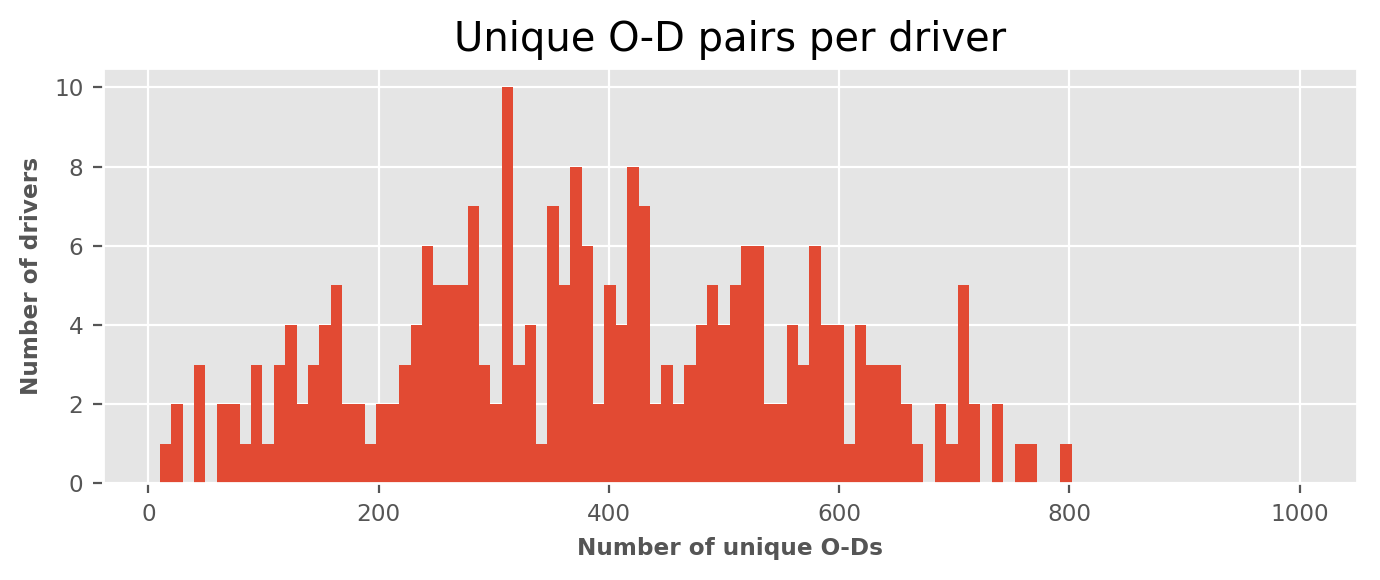

In [8]:
nunique_per_user = np.diff(user_items.tocsr().indptr)
set_plt_style()
histogram(nunique_per_user,xlabel='Number of unique O-Ds',ylabel='Number of drivers',title='Unique O-D pairs per driver',hist_max=1000,bins=100,figscale=1)

<a id='modeling'></a>
## Build Model
The Matrix Factorization model is built using the [implicit](https://github.com/benfred/implicit) library. The algorithm is based on the paper [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf) by Hu et al (2008). The parameters can be tuned further to improve accuracy. 

In [9]:
s = time.time()
model = implicit.als.AlternatingLeastSquares(factors=10,
                                            regularization=0.1,
                                            iterations=30)
alpha=2
item_users_train = user_items_train.transpose()
model.fit(item_users_train*alpha)
print(f'Time taken to build model: {time.time()-s:.2f}s')

100%|██████████| 30.0/30 [00:01<00:00, 27.79it/s]

Time taken to build model: 1.20s


## Validate
The accuracy was calculated using recall metrics. For each user in test set, recall is:
    
    (# items in predictions AND test set) / (# items in test set)
    
The accuracy was averaged across all users.
<br/>

In this single validation, I set N = 100, where N is the number of recommended items per user.

In [19]:
N = 100
validate(model,user_items,user_items_train,test_users,N=N,k=k)


Accuracy (Recall)
----------
Model: 16.373%
Benchmark: 12.353%

[Parameters: k=20, N=100]


<a id='graph'></a>
## Validate (Percentile Ranking)
A more general assessment of the model can be done using **percentile ranking**. This is described in the [paper](http://yifanhu.net/PUB/cf.pdf) by Hu et al. 

The percentile refers to the top N recommendations as a proportion of all O-D combinations. 

The **model** recommends a custom set of top N recommendations to each user. 
<br/>
The **benchmark** recommends the top N most popular O-D pairs to each user. Popularity was measured by total frequency of each O-D route across all users.

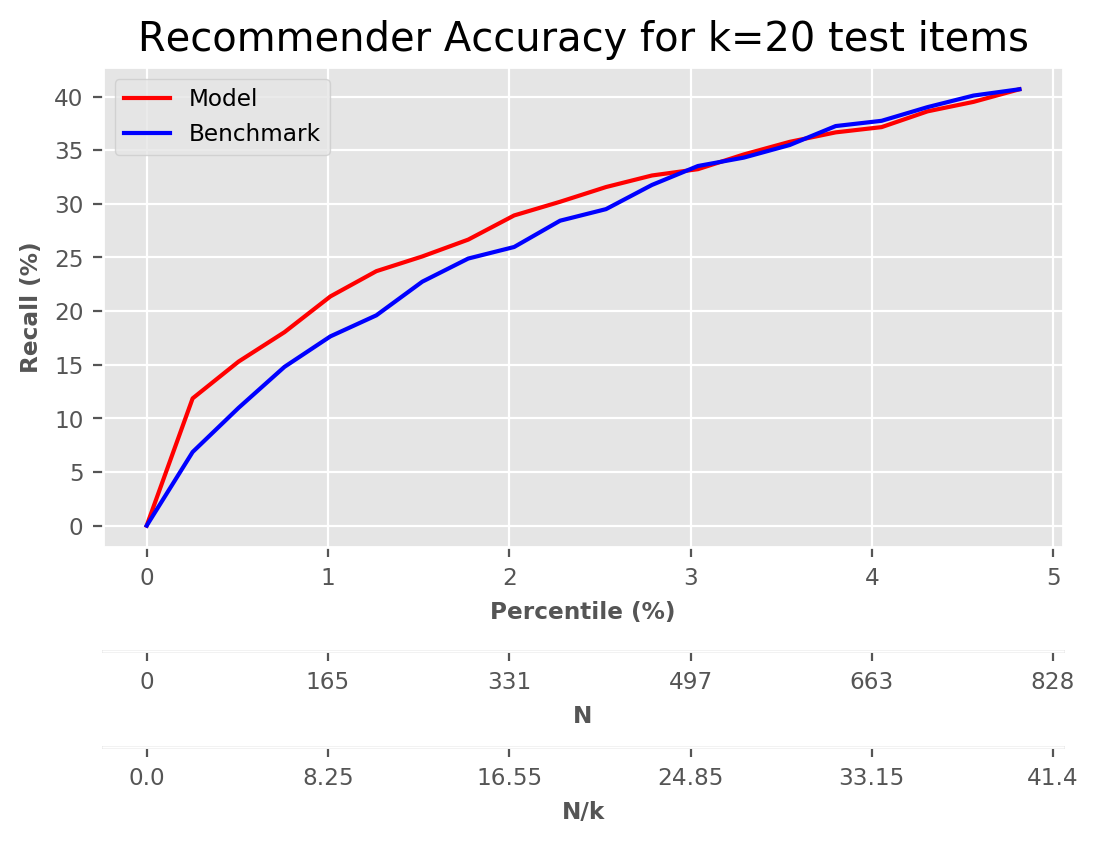

In [20]:
%%capture --no-display
pcts, model_acc, benchmark_acc = validate_pct_rank(model,
                                                   user_items,
                                                   user_items_train,
                                                   test_users,
                                                   min_pct=0,
                                                   max_pct=5)
plot_pct_rank(pcts,model_acc,benchmark_acc,num_items,k)

## Analysis
The graph above shows the model accuracy for a range of N values, with k=20. 

A realistic value for N could be between 1 to 20 times of k, i.e. N=20 to N=400. Within this range, the Recommender System model **outperforms** the benchmark model. We likely do not need to consider higher values of N since recommender systems typically do not recommend many items at once. 

As shown earlier, in the specific case where N=100, the model accuracy is **~16%** compared to **~12%** in the benchmark. 

-----
<a id='conclusion'></a>
# 3 Conclusion

This model recommends new O-D routes that drivers have not interacted with before on the company's mobile app. The algorithm is a form of weighted, regularized Matrix Factorization, described in the paper by Hu et al. (2008). 

The model outperforms the simple benchmark model. Hence, this model can recommend more personalized O-D routes compared to simply recommending the most popular items. 

The Python library used to implement Matrix Factorization is also extremely fast. Modeling was almost completed in under 1 second. See [above](#modeling).

## Limitation
One limitation of this model is the cold-start problem for new users. This model requires some knowledge of a user's mobile app usage history.

An area for improvement is to incorporate the driver's context, such as location. Such a model is called *Context-Aware Collaborative Filtering*. For instance, a driver's current location would likely influence his/her preference of O-D routes. 


-----
<a id='appendix'></a>
# 4 Appendix

## Further Reading
1. An alternative, open source library for Matrix Factorization was released by [**Quora**](https://quora.com). See their announcement [here](https://engineering.quora.com/Open-sourcing-QMF-for-matrix-factorization). 
<br/>
<br/>
2. The code was adapted from these blogs:
    * https://towardsdatascience.com/recommending-github-repositories-with-google-bigquery-and-the-implicit-library-e6cce666c77
    * https://jessesw.com/Rec-System/